# Anomaly detection for Electroconductivity
### [based on the book Hacker's Guide to Machine Learning](https://github.com/curiousily/Deep-Learning-For-Hackers), [(video)](https://www.youtube.com/watch?v=H4J74KstHTE&ab_channel=VenelinValkov)

## A solution by

![DATARICS LOGO](DATARICS.png)

![Milieuegy LOGO](Milieuegy.png)

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from pylab import rcParams
from matplotlib import rc

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
mijn_omgeving = pd.read_csv('mijnomgeving.csv', index_col='datetime', parse_dates=True)

In [4]:
mijn_omgeving.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 780309 entries, 2019-10-01 00:00:00.485000 to 2020-04-26 03:59:37.645000
Data columns (total 23 columns):
app_id              780309 non-null object
dev_id              780309 non-null int64
time                780309 non-null int64
FixAge              780309 non-null float64
Lat                 746444 non-null float64
Lon                 746444 non-null float64
SatInFix            746444 non-null float64
TimeActive          780309 non-null float64
altitude            746444 non-null float64
batteryVoltage      780309 non-null float64
boardTemperature    780309 non-null float64
course              746444 non-null float64
imei                780309 non-null float64
lastResetCause      780308 non-null float64
speed               746443 non-null float64
timestamp           780308 non-null float64
waterEC             780308 non-null float64
waterTemperature    780308 non-null float64
name                779955 non-null object
year       

In [5]:
mijn_omgeving.isna().sum()

app_id                   0
dev_id                   0
time                     0
FixAge                   0
Lat                  33865
Lon                  33865
SatInFix             33865
TimeActive               0
altitude             33865
batteryVoltage           0
boardTemperature         0
course               33865
imei                     0
lastResetCause           1
speed                33866
timestamp                1
waterEC                  1
waterTemperature         1
name                   354
year                     1
month                    1
day                      1
pH                  773573
dtype: int64

In [6]:
# The Hague sensor

In [7]:
EC_236 = mijn_omgeving[mijn_omgeving['name'] == 'EC 236']

In [8]:
wt_tha = EC_236['waterTemperature']

In [9]:
ec_tha = EC_236['waterEC']

[Text(0, 0.5, 'Water Temperature'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Water Temperature in The Hague')]

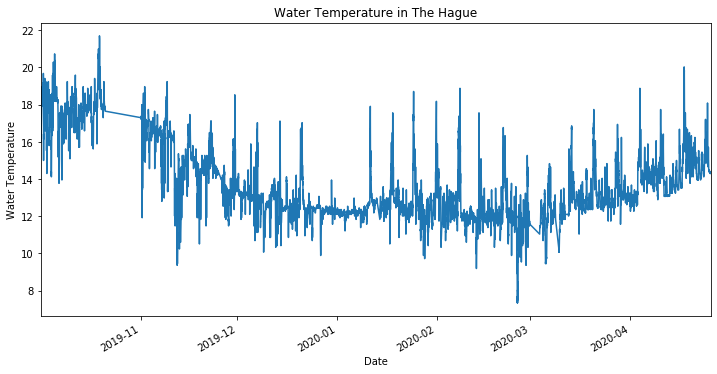

In [10]:
ax = wt_tha.plot(figsize=(12,6))
ax.autoscale(axis='x', tight = True)
ax.set(xlabel='Date', ylabel='Water Temperature', title='Water Temperature in The Hague')

[Text(0, 0.5, 'Water Electroconductivity'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Water Electroconductivity in The Hague')]

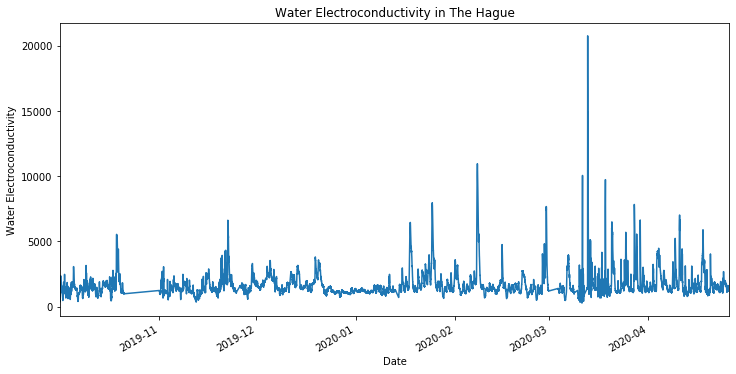

In [11]:
ax = ec_tha.plot(figsize=(12,6))
ax.autoscale(axis='x', tight = True)
ax.set(xlabel='Date', ylabel='Water Electroconductivity', title='Water Electroconductivity in The Hague')

In [12]:
# The Hague Anomaly Detection with LSTM Autoencoders

In [13]:
df_ec_tha = pd.DataFrame(ec_tha)

In [14]:
df_ec_tha.head()

,waterEC
datetime,
2019-10-01 00:06:03.012,1319.0
2019-10-01 00:21:01.292,1182.0
2019-10-01 00:36:18.025,1144.0
2019-10-01 00:50:59.971,1067.0
2019-10-01 01:06:02.992,867.0


In [15]:
df_wt_tha = pd.DataFrame(wt_tha)

In [16]:
df_wt_tha.head()

,waterTemperature
datetime,
2019-10-01 00:06:03.012,18.00
2019-10-01 00:21:01.292,18.00
2019-10-01 00:36:18.025,18.00
2019-10-01 00:50:59.971,17.38
2019-10-01 01:06:02.992,15.97


In [17]:
df_len = len(df_ec_tha)

In [18]:
train_size = int(df_len * 0.95)
test_size = df_len - train_size
train, test = df_ec_tha.iloc[0:train_size], df_ec_tha.iloc[train_size:df_len]
print(train.shape, test.shape)

(17357, 1) (914, 1)


In [19]:
scaler = StandardScaler()
scaler = scaler.fit(train[['waterEC']])

train['waterEC'] = scaler.transform(train[['waterEC']])
test['waterEC'] = scaler.transform(test[['waterEC']])

In [20]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [21]:
TIME_STEPS = 30

# Reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['waterEC']], train.waterEC, TIME_STEPS)
X_test, y_test = create_dataset(test[['waterEC']], test.waterEC, TIME_STEPS)

print(X_train.shape)

(17327, 30, 1)


In [22]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [23]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Train on 15594 samples, validate on 1733 samples
Epoch 1/10
15594/15594 [==============================] - 19s 1ms/sample - loss: 0.1554 - val_loss: 0.0917
Epoch 2/10
15594/15594 [==============================] - 15s 941us/sample - loss: 0.1155 - val_loss: 0.0803
Epoch 3/10
15594/15594 [==============================] - 14s 872us/sample - loss: 0.0968 - val_loss: 0.0720
Epoch 4/10
15594/15594 [==============================] - 14s 872us/sample - loss: 0.0982 - val_loss: 0.0671
Epoch 5/10
15594/15594 [==============================] - 15s 941us/sample - loss: 0.0930 - val_loss: 0.0717
Epoch 6/10
15594/15594 [==============================] - 14s 869us/sample - loss: 0.0927 - val_loss: 0.0827
Epoch 7/10
15594/15594 [==============================] - 15s 984us/sample - loss: 0.0933 - val_loss: 0.0781
Epoch 8/10
15594/15594 [==============================] - 15s 985us/sample - loss: 0.0886 - val_loss: 0.0651
Epoch 9/10
15594/15594 [==============================] - 13s 841us/sample - loss

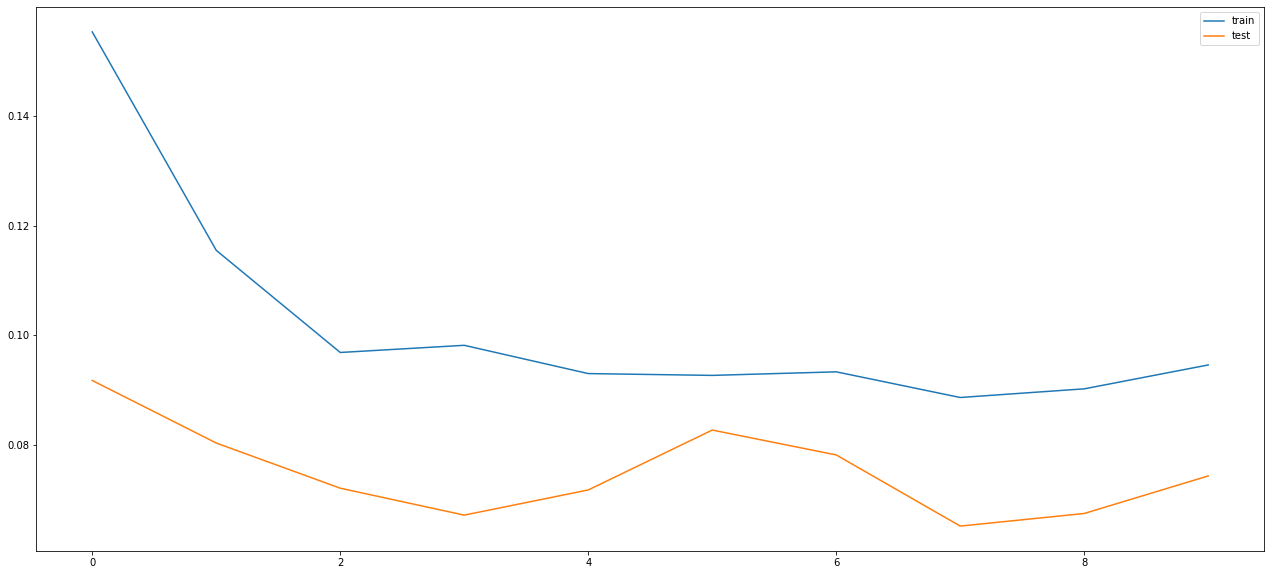

In [24]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [25]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

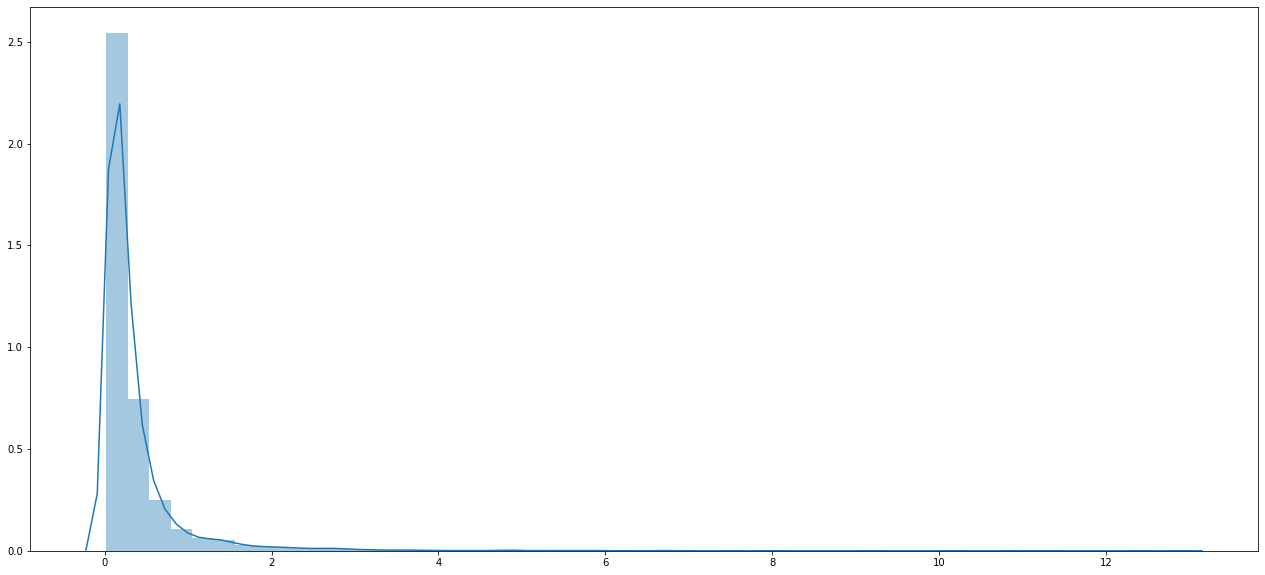

In [26]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [27]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [28]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['waterEC'] = test[TIME_STEPS:].waterEC

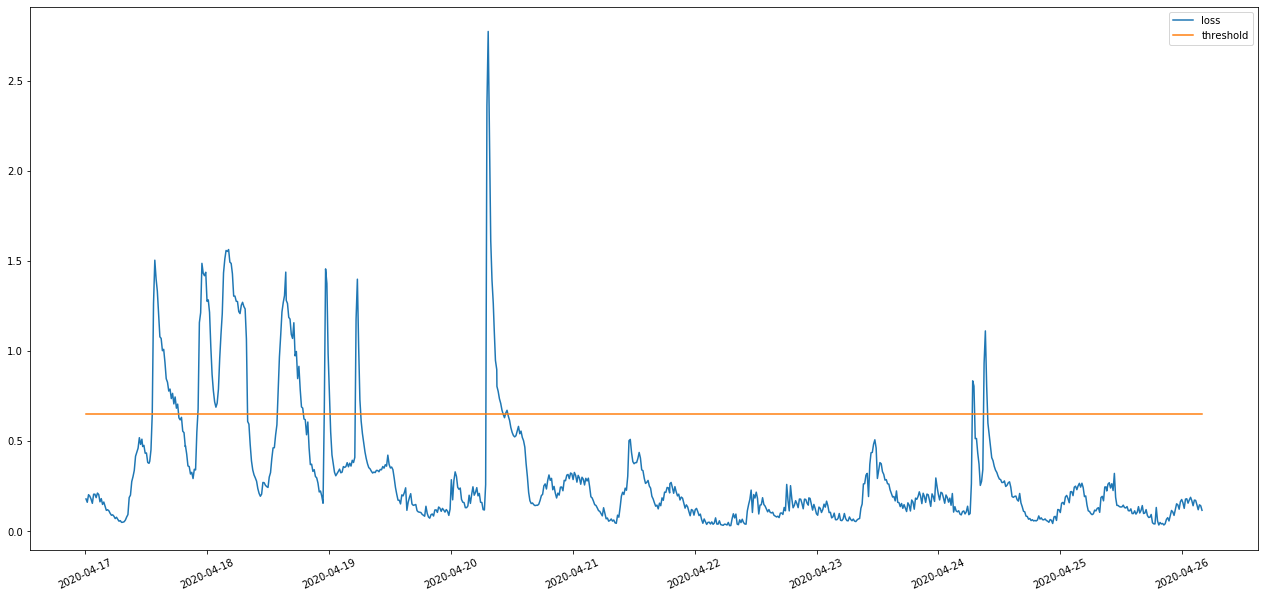

In [29]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [30]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,waterEC
datetime,,,,
2020-04-17 13:31:18.826,1.261878,0.65,True,1.466012
2020-04-17 13:46:33.695,1.503195,0.65,True,1.530649
2020-04-17 14:01:39.644,1.399878,0.65,True,1.579127
2020-04-17 14:16:16.741,1.331804,0.65,True,1.514490
2020-04-17 14:31:16.575,1.200061,0.65,True,1.435595


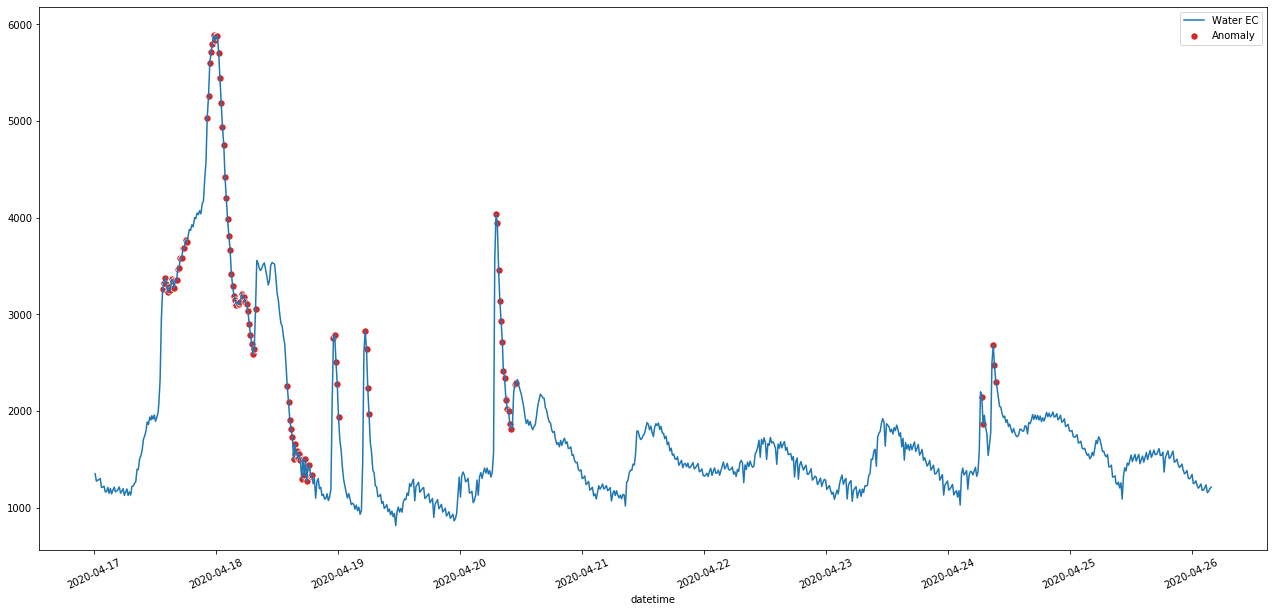

In [31]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].waterEC), 
  label='Water EC'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.waterEC),
  color=sns.color_palette()[3],
  s=52,
  label='Anomaly'
)
plt.xticks(rotation=25)
plt.legend();

In [35]:
anomalies_ = pd.DataFrame(scaler.inverse_transform(anomalies))

In [36]:
anomalies_.to_csv('anomalies.csv')

In [37]:
train_ = pd.DataFrame(scaler.inverse_transform(train))

In [39]:
train_.to_csv('train.csv')

In [40]:
test_ = pd.DataFrame(scaler.inverse_transform(test))

In [41]:
test_.to_csv('test.csv')

# End of the notebook